(1a) Load the SpotifyFeatures.csv file and report the number of samples (songs) as well as the number of
features (song properties) in the dataset. Hint: you may use the Python module Pandas and its function
read_csv.

In [1]:
import pandas as pd

"""
Reading in the data from the SpotifyFeatures.csv file and reporting the number of samples
and features
"""
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

spotify_data = pd.read_csv("SpotifyFeatures.csv")

print(f'Total samples: {spotify_data.shape[0]}')

features = spotify_data.columns[1:]

print(f'Feautres: {len(features)}')


Total samples: 232725
Feautres: 17


(1b) You will be working with samples from two genres namely ’Pop’ and ’Classical’. Retrieve all samples
belonging to the two genres and create labels for the samples i.e: ’Pop’ = 1, ’Classical’ = 0. Report how
many samples belongs to the two classes. Working with all features is not always the best solution since
it increases the computational cost and some of them may be useless for the task. For this dataset you
should be able to separate the two classes by using two features, namely ’liveness’ and ’loudness’.

In [2]:
import numpy as np

"""
Reducing dataset to only include pop and classical samples
"""

filtered_samples = spotify_data[spotify_data['genre'].isin(['Pop', 'Classical'])].copy()

filtered_samples.loc[filtered_samples['genre'] == 'Pop', 'label'] = 1
filtered_samples.loc[filtered_samples['genre'] == 'Classical', 'label'] = 0


print(f"Pop samples: {filtered_samples.loc[filtered_samples['label'] == 1].shape[0]}")
print(f"Classical samples: {filtered_samples.loc[filtered_samples['label'] == 0].shape[0]}")

Pop samples: 9386
Classical samples: 9256


(1c) From the reduced dataset, make 2 numpy arrays. The first array will be the matrix with songs along the
rows and songs’ features ("liveness" and "loudness") as columns. This will be the input of our machine
learning method. The second array will the vector with the songs’ genre (labels or target we want to
learn). Create a training and test set by splitting the dataset. Use an 80% 20% split between the training
and test set. Split the data per class so that you keep the same class distribution in the training and test
set.

In [3]:
from sklearn.model_selection import train_test_split

# Splitting dataset
X = filtered_samples[['liveness', 'loudness']].to_numpy()  
labels = filtered_samples['label'].to_numpy() 

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=1)

(1d) Bonus.] Plot the samples on the liveness vs loudness plane, with a different color for each class. From the
plot, will the classification be an easy task? why?

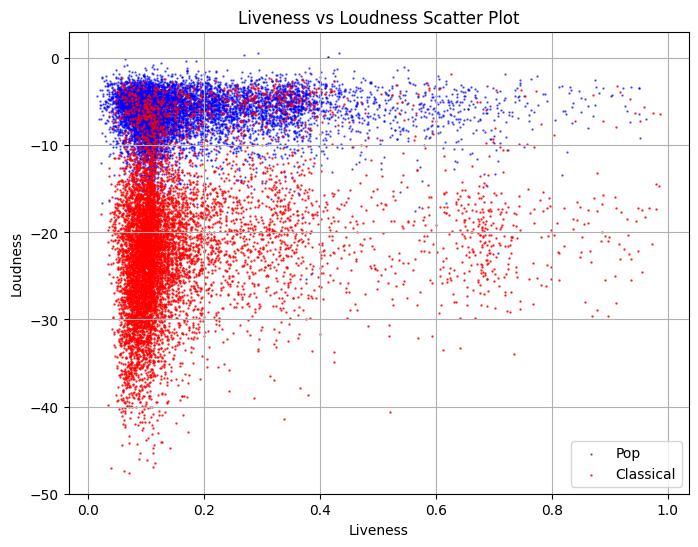

In [4]:
import matplotlib.pyplot as plt

# Plotting liveness vs loudness plot
plt.figure(figsize=(8, 6))

pop_samples = filtered_samples[filtered_samples['label'] == 1]
plt.scatter(pop_samples['liveness'], pop_samples['loudness'], color='blue', label='Pop', alpha=0.6, s=0.5)

classical_samples = filtered_samples[filtered_samples['label'] == 0]
plt.scatter(classical_samples['liveness'], classical_samples['loudness'], color='red', label='Classical', alpha=0.8, s=0.5)

plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.title('Liveness vs Loudness Scatter Plot')
plt.legend()
plt.grid(True)

plt.show()



(2a) Implement your own logistic discrimination classifier and use the training data to train the classifier. You
should use stochastic gradient descent and implement it in Python. Plot the training error as a function of
epochs, and report the accuracy on the training set. Try different learning rates for the gradient descent
and explain what you observe for these different values. Optional, it may help the learning process if the
data is shuffled (songs are fed to the classifier in random order).

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Implementation of logsitic regression that utilizes stochastic gradient descent for estimating the weights
class LogisticRegression():

    #Inputs to the class is learning rate and number of epochs
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None

    #The cross entropy loss function is used to estimate the loss after every epoch
    def cross_entropy_loss(self, y_hat, y):
        number_of_samples = X.shape[0]
        epsilon = 1e-15  # To prevent log(0)
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        loss = (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return -np.mean(loss)
    
    # The logistic function, used for predicting the label.
    def sigmoid_function(self, parameters):
        return 1 / (1 + np.exp(-parameters))

    # Computing the gradient with our features, the predicted label and the actual label. stochastic gradient descent
    def compute_gradient(self, features, y, y_hat):
        features = np.append(features, 1)
        return features * (y_hat - y)
    
    # The fit function adapted from the lecture slide pseudocode. iterates over every sample, predicts label and perform stochastic gradient descent to update weights.
    def fit(self, X, labels):
        training_errors = []
        number_of_samples, number_of_features = X.shape
        self.weights = np.ones(number_of_features + 1) 

        for epoch in range(self.epochs):
            error = 0
            # Shuffling the dataset before every epoch
            indices = np.random.permutation(number_of_samples)
            X_shuffled = X[indices]
            labels_shuffled = labels[indices] 

            for i in range(number_of_samples):
                features = X_shuffled[i]
                y = labels_shuffled[i]
                y_hat = self.predict(features)
                error += self.cross_entropy_loss(y_hat, y)
                
                gradient = self.compute_gradient(features, y, y_hat)
                self.weights -= self.learning_rate * gradient  # Update weights
            
            # Calculating average loss from the last epoch
            avg_epoch_loss = error / number_of_samples
            training_errors.append(avg_epoch_loss)

        # Plot training error vs. number of epochs
        plt.plot(range(self.epochs), training_errors)
        plt.xlabel('Epochs')
        plt.ylabel('Training Error')
        plt.title('Training Error vs. Number of Epochs')
        plt.show()

    # Predicts the label 
    def predict(self, features):
        features = np.append(features, 1)
        parameters = self.weights @ features
        return self.sigmoid_function(parameters)
    
    # Only used to predict labels from the test set
    def predict_test_set(self, X):

        X = np.c_[X, np.ones(X.shape[0])]  
        z = np.dot(X, self.weights) 
        return self.sigmoid_function(z)
    
    # Calculates the accuracy of the model
    def compute_accuracy(self, X_matrix, label):
        predictions = np.array([self.predict(x) for x in X_matrix])
        predicted_labels = (predictions >= 0.5).astype(int)
        accuracy = np.mean(predicted_labels == label)
        return accuracy
    
    # Creates a confusion matrix based on the results from classifying the testset
    def evaluate(self, X_test, y_test):
        test_predictions_prob = self.predict_test_set(X_test)
        test_predictions = (test_predictions_prob >= 0.5).astype(int)
        
        cm = confusion_matrix(y_test, test_predictions)
        

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classical', 'Pop'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix for Logistic Regression on Test Set")
        plt.show()
             


Running Logistic Regression with learning rate: 0.01


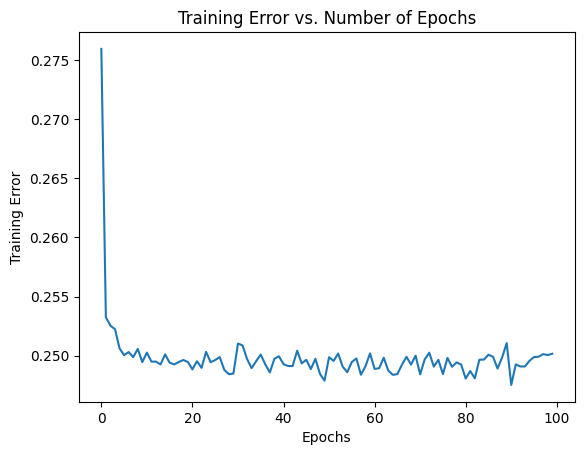

Learned Weights: [-1.96610143  0.59589012  5.95283212]
Training Accuracy with learning rate 0.01: 89.91%

Running Logistic Regression with learning rate: 0.001


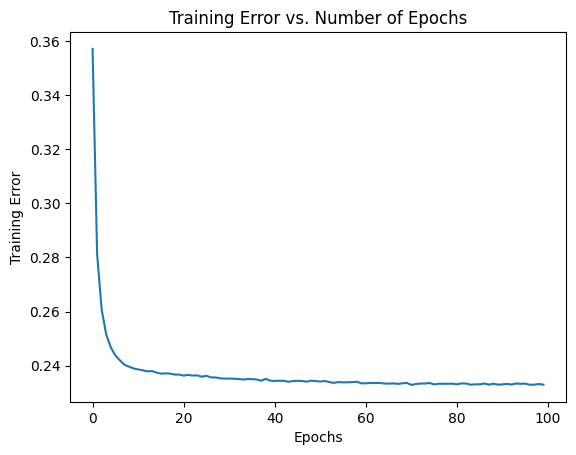

Learned Weights: [-1.29236146  0.44577987  5.38693191]
Training Accuracy with learning rate 0.001: 92.64%

Running Logistic Regression with learning rate: 0.0001


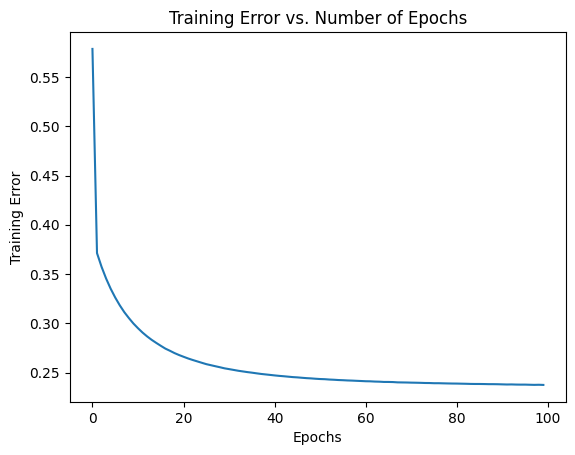

Learned Weights: [0.9781836  0.40331606 4.53249017]
Training Accuracy with learning rate 0.0001: 92.68%


In [24]:
learning_rates = [0.01, 0.001, 0.0001]
# Loops through the learning rates and runs the model with different learning rates
for lr in learning_rates:
    print(f"\nRunning Logistic Regression with learning rate: {lr}")
    
    model = LogisticRegression(learning_rate=lr, epochs=100)
    
    model.fit(X_train, y_train)
    
    print("Learned Weights:", model.weights)

    training_accuracy = model.compute_accuracy(X_train, y_train)
    print(f"Training Accuracy with learning rate {lr}: {training_accuracy * 100:.2f}%")

2(b) est your trained logistic discrimination classifier using the test set. Report the accuracy on the test set.
Is there a significant difference between the accuracy on the training and test set? If so what might that
indicate. [Optional] Inform (or brag) about your test accuracy score on Discord. It is nice to seen how
other students perform while working on the assignment.

In [25]:
testing_accuracy = model.compute_accuracy(X_test, y_test)
print(f"Testing Accuracy: {testing_accuracy * 100:.2f}%")

Testing Accuracy: 92.57%


(2c)

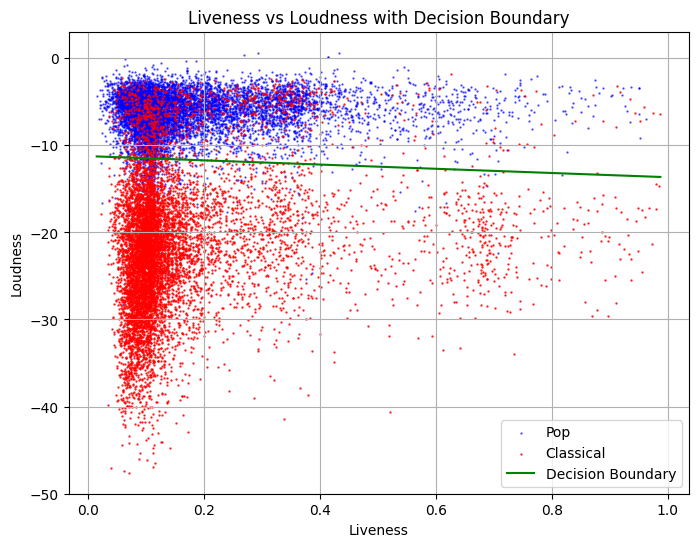

In [28]:
import numpy as np
import matplotlib.pyplot as plt

weights = model.weights

plt.figure(figsize=(8, 6))

pop_samples = filtered_samples[filtered_samples['label'] == 1]
plt.scatter(pop_samples['liveness'], pop_samples['loudness'], color='blue', label='Pop', alpha=0.6, s=0.5)

classical_samples = filtered_samples[filtered_samples['label'] == 0]
plt.scatter(classical_samples['liveness'], classical_samples['loudness'], color='red', label='Classical', alpha=0.8, s=0.5)

x_values = np.linspace(filtered_samples['liveness'].min(), filtered_samples['liveness'].max(), 100)

# Equation for straight line given two weights and two features, but reaaranged for y_values (loudness)
y_values = -(weights[0] / weights[1]) * x_values - (weights[2] / weights[1])

plt.plot(x_values, y_values, color='green', label='Decision Boundary')

plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.title('Liveness vs Loudness with Decision Boundary')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

(3a)

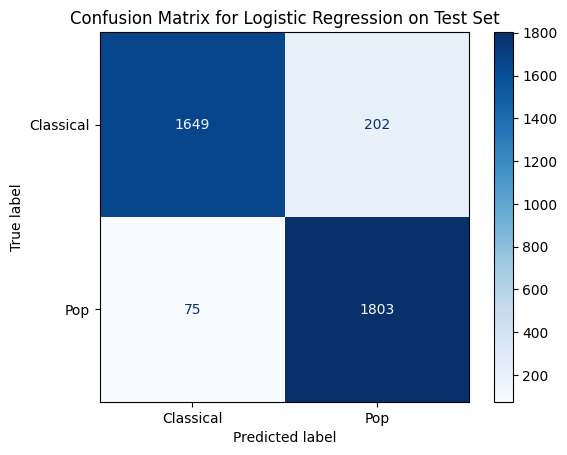

In [29]:
# Generating confusion matrix from the test data
conf_matrix = model.evaluate(X_test, y_test)

(3d)

In [15]:
classical_songs = filtered_samples[filtered_samples['genre'] == 'Classical']

#Finding the song the classical song that has the highest loudness (might indicate more similar to pop song)
classical_song_max_loudness = classical_songs.loc[classical_songs['loudness'].idxmax()]

print(classical_song_max_loudness)

genre                            Classical
artist_name                  Richie Kotzen
track_name                       Go Faster
track_id            7qLq9x0er8eP04MIaxwK0Y
popularity                              43
acousticness                         0.133
danceability                         0.504
duration_ms                         175773
energy                               0.939
instrumentalness                   0.00758
key                                      C
liveness                             0.626
loudness                            -1.786
mode                                 Minor
speechiness                         0.0554
tempo                               118.09
time_signature                         4/4
valence                              0.741
label                                  0.0
Name: 127261, dtype: object
